# Quora Insincere Questions classification based on Token Counts
## using sklearn logistic regression
## using spacy to clean data

In [1]:
import re
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
WORKING_DIR = os.path.join('.input', 'clean_token_counts_logistic')

In [3]:
quora = pd.read_csv('../data/.input/train.csv', nrows=20_000)

In [4]:
quora.head(10)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


In [6]:
import spacy

nlp = spacy.load('en_core_web_md', disable=["parser", "ner"])

In [7]:
def clean_data(text):
    doc = nlp(text)
    return ' '.join([token.lemma_.lower() for token in doc if not token.is_punct and not token.is_stop])

print(quora.question_text.iloc[0])
print(clean_data(quora.question_text.iloc[0]))

How did Quebec nationalists see their province as a nation in the 1960s?
how do quebec nationalist see -pron- province as a nation in the 1960


In [8]:
%%time

quora['clean_question_text'] = quora.question_text.apply(clean_data)
quora.head(10)

Wall time: 1min 34s


In [9]:
quora_train, quora_test = train_test_split(quora, random_state=42)
quora_train_data = quora_train.clean_question_text
quora_train_labels = quora_train.target
quora_test_data = quora_test.clean_question_text
quora_test_labels = quora_test.target

In [10]:
%time
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

train_X = vectorizer.fit_transform(quora_train_data)
train_y = quora_train_labels

Wall time: 0 ns


In [11]:
test_X = vectorizer.transform(quora_test_data)
test_y = quora_test_labels

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score, roc_curve

import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

def report_results(clf, test_X, test_y):
    test_predict_proba = clf.predict_proba(test_X)
    test_predict_proba_pos = test_predict_proba[:, 1]
    auc = roc_auc_score(test_y, test_predict_proba_pos)
    curve = roc_curve(test_y, test_predict_proba_pos)


    plt.plot(curve[0], curve[1]);
    plt.plot([0,1], [0,1])
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('test AUC = %f' % (auc)); plt.axis([-0.05,1.05,-0.05,1.05]);
    
    to_labels = np.vectorize(lambda x: 1 if x > 0.5 else 0)
    test_predict = to_labels(test_predict_proba_pos)

    print('accuracy', accuracy_score(test_y, test_predict))
    print('precision', precision_score(test_y, test_predict))
    print('recall', recall_score(test_y, test_predict))
    print('f1', f1_score(test_y, test_predict))
    print('AUC', auc)
    confusion_matrix(test_y, test_predict)


## Logistic Regression

In [13]:
%%time

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='saga', C = 0.5, class_weight='balanced', random_state=42, max_iter=500)
clf.fit(train_X, train_y)

Wall time: 3.43 s


accuracy 0.919
precision 0.38589211618257263
recall 0.6305084745762712
f1 0.4787644787644788
AUC 0.8948864352744106


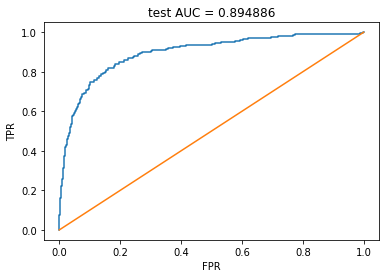

In [14]:
report_results(clf, test_X, test_y)

## Grid Search

In [18]:
%%time

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

params_grid = [{'solver': ['saga'], 'C': [0.1, 0.5, 5.0], 'class_weight': [None, 'balanced'], 'penalty': ['l1', 'l2']},
               {'solver': ['newton-cg', 'sag'], 'C': [0.1, 0.5, 5.0], 'class_weight': [None, 'balanced'], 'penalty': ['l2']}]

clf = LogisticRegression(random_state=42, max_iter=500)

grid_search = GridSearchCV(clf, params_grid, cv=5, return_train_score=True, scoring='f1', n_jobs=-1)

grid_search.fit(train_X, train_y)

Wall time: 3min 57s


In [19]:
for score, params in zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params']):
        print(score, params)

print('\nbest params', grid_search.best_params_)

0.2243648989771229 {'C': 0.1, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}
0.2649961236350013 {'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}
0.41301164303957966 {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}
0.46614685883923923 {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
0.3817005647282761 {'C': 0.5, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}
0.3922639289771967 {'C': 0.5, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}
0.4904163032628928 {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}
0.49409445547512937 {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
0.448270307590733 {'C': 5.0, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}
0.44292075671771397 {'C': 5.0, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}
0.4765131945057335 {'C': 5.0, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}
0.48055928

accuracy 0.92
precision 0.389937106918239
recall 0.6305084745762712
f1 0.4818652849740932
AUC 0.8956688701165367


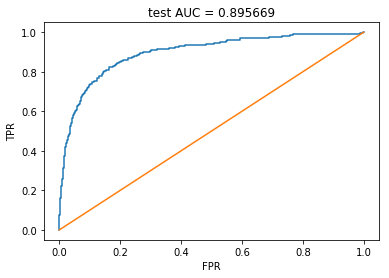

In [20]:
report_results(grid_search.best_estimator_, test_X, test_y)